
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

/Users/williamdrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/williamdrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/williamdrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/williamdrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/williamdrew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/williamd


## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>1.1
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good job on this question! Consider showing the dataframe summary using describe() as well. You can review the min and max values from the describe output to validate the results of your normalization. They should be between 0 and 1. No points deducted.
</span></div></div>

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
# Normalize values of each predictor in the train set

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)


In [5]:
X_train_scaled.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
486,0.574689,0.652904,0.528552,0.202384,0.504132,0.309107,0.439480,0.524446,0.723161,0.411162,0.621681,0.321146,...,0.477952,0.622254,0.516278,0.391074,0.752595,0.484137,0.683508,0.389115,0.413169,0.562775,0.538180,0.524258
604,0.587407,0.535608,0.249427,0.171417,0.752874,0.513878,0.655342,0.464181,0.324602,0.559483,0.674740,0.341671,...,0.435211,0.519185,0.635019,0.317177,0.700050,0.336964,0.454571,0.406687,0.339430,0.452814,0.388218,0.380795
341,0.446787,0.630576,0.554963,0.413946,0.662329,0.665892,0.145850,0.648430,0.478307,0.551411,0.289416,0.329466,...,0.410134,0.253019,0.439609,0.233910,0.235984,0.343672,0.733797,0.369846,0.323172,0.500478,0.457391,0.556345
117,0.568391,0.666018,0.735454,0.564376,0.662796,0.302675,0.513584,0.359108,0.706408,0.272227,0.395238,0.394697,...,0.474741,0.450396,0.574234,0.449615,0.426995,0.390941,0.650875,0.615891,0.251946,0.695112,0.436069,0.458655
516,0.532581,0.834889,0.357527,0.447480,0.631015,0.198841,0.678084,0.515280,0.487490,0.440010,0.505418,0.301920,...,0.263812,0.532818,0.539831,0.543511,0.528163,0.442338,0.578272,0.404435,0.531047,0.372191,0.751796,0.469227


In [6]:
# Also normalize predictors in the testing data using the scaling parameters learned from training

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns=X_test.columns)

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>1.2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Reshaping the predictor matrix is not necessary here. Please take a look at the HW solution for further reference. No points deducted.</span></div></div>

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [7]:
# Prepare X data for training and testing for logistic regression in sklearn
# Form arrays where each row holds domain for each predictor
X_train_scaled_multi_reshape = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1])
X_test_scaled_multi_reshape = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1])
# Check sizes
print('Training sizes:', X_train_scaled_multi_reshape.shape, y_train.shape)
# Check sizes
print('Testing sizes:', X_test_scaled_multi_reshape.shape, y_test.shape)


Training sizes: (601, 7129) (601,)
Testing sizes: (151, 7129) (151,)


In [8]:
# Fit multiple logistic regression

multi_logreg = LogisticRegression(C=100000, fit_intercept=True, solver='liblinear')
# I am using the default solver = liblinear because it is most appropriate for small samples per the sklearn documentation and therefore it may have the most power
# I am using the default for max_iter = 100 because it is most efficient and the model converges with it
# I am using an intercept because it does not make sense to constrain the intercept to 0 for this model. There can be a baseline risk of AML vs. ALL without any expression of the best predictor gene

multi_logreg.fit(X_train_scaled_multi_reshape, y_train)

# Predictions on training set
multi_logreg_y_hat_train = multi_logreg.predict(X_train_scaled_multi_reshape)

# Predictions on testing set
multi_logreg_y_hat_test = multi_logreg.predict(X_test_scaled_multi_reshape)

# Evaluate accuracy on training set
print('Multiple logistic regression misclassification rate on training set:', 1-accuracy_score(y_train, multi_logreg_y_hat_train))

# Evaluate accuracy on testing set
print('Multiple logistic regression misclassification rate on testing set:', 1-accuracy_score(y_test, multi_logreg_y_hat_test))

Multiple logistic regression misclassification rate on training set: 0.0
Multiple logistic regression misclassification rate on testing set: 0.23178807947019864


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [9]:
# Multiple logistic regression with LASSO regularization (L1 norm)

Cs = 10.0**np.arange(-5,5)

logregCV_q4 = LogisticRegressionCV(Cs = Cs,cv=5,solver='liblinear',penalty='l1')
# Use liblinear solver because it is best for small samples and so has high power and leave max_iter at the default of 100 because model converges with it and is more efficient than using higher numbers for max_iter
# Use a range of Cs as shown in the lab and use cv = 5 to perform 5-fold cross validation as modeled in the lab
model_logregCV_q4 = logregCV_q4.fit(X_train_scaled_multi_reshape, y_train)

In [10]:
# Predictions on training set
logregCV_q4_y_hat_train = logregCV_q4.predict(X_train_scaled_multi_reshape)

# Predictions on testing set
logregCV_q4_y_hat_test = logregCV_q4.predict(X_test_scaled_multi_reshape)

# Evaluate accuracy on training set
print('Multiple logistic regression misclassification rate on training set after regularization:', 1-accuracy_score(y_train, logregCV_q4_y_hat_train))

# Evaluate accuracy on testing set
print('Multiple logistic regression misclassification rate on testing set after regularization:', 1-accuracy_score(y_test, logregCV_q4_y_hat_test))

Multiple logistic regression misclassification rate on training set after regularization: 0.04658901830282858
Multiple logistic regression misclassification rate on testing set after regularization: 0.1589403973509934


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>1.4
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great job on this question. Your presentation of the results is very clear.
</span></div></div>

**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [11]:
ks = [1,2,3,4,5,7,9,10,15,25]
for k in ks:
    knn = KNeighborsClassifier(k)
    cv_scores = cross_val_score(knn, X_train_scaled_multi_reshape, y_train, cv=5)
    print("K = "+ str(k))
    print(cv_scores)
    print("Mean = " + str(np.mean(cv_scores))+"\n")


K = 1
[0.85950413 0.78512397 0.79338843 0.81512605 0.82352941]
Mean = 0.8153343982220986

K = 2
[0.84297521 0.80165289 0.7768595  0.77310924 0.81512605]
Mean = 0.8019445794846864

K = 3
[0.88429752 0.85123967 0.83471074 0.86554622 0.8907563 ]
Mean = 0.8653100909785403

K = 4
[0.85950413 0.80991736 0.80165289 0.80672269 0.89915966]
Mean = 0.8353913466212932

K = 5
[0.87603306 0.85123967 0.84297521 0.81512605 0.89915966]
Mean = 0.8569067296340025

K = 7
[0.90909091 0.85123967 0.87603306 0.84033613 0.89915966]
Mean = 0.8751718869365929

K = 9
[0.90082645 0.85123967 0.89256198 0.83193277 0.88235294]
Mean = 0.8717827626918536

K = 10
[0.85950413 0.79338843 0.88429752 0.83193277 0.87394958]
Mean = 0.848614487117161

K = 15
[0.88429752 0.76033058 0.87603306 0.79831933 0.84033613]
Mean = 0.8318633238419334

K = 25
[0.76859504 0.66942149 0.78512397 0.71428571 0.78991597]
Mean = 0.7454684353080075



We choose $k=7$ because it has the highest mean score across the five folds.

In [12]:
knn = KNeighborsClassifier(7)
knn.fit(X_train_scaled_multi_reshape, y_train)

print("Misclassification rate on Train set: " + str(1-knn.score(X_train_scaled_multi_reshape, y_train)))
print("Misclassification rate on Test set: " + str(1-knn.score(X_test_scaled_multi_reshape, y_test)))

Misclassification rate on Train set: 0.09816971713810319
Misclassification rate on Test set: 0.13907284768211925


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

Confusion matrix for multiple regression with no regularization

In [13]:
y_test_multi_logreg = multi_logreg.predict(X_test_scaled_multi_reshape)
conf_mat_multi_logreg = pd.crosstab(y_test, y_test_multi_logreg, colnames=['Predicted'],rownames = ['Actual'])
conf_mat_multi_logreg

Predicted,0.0,1.0
Actual,,
0.0,65,12
1.0,23,51


In [14]:
print("The false positive rate is "+str(conf_mat_multi_logreg[1][0]/(conf_mat_multi_logreg[1][0] + conf_mat_multi_logreg[0][0])))
print("The false negative rate is "+str(conf_mat_multi_logreg[0][1]/(conf_mat_multi_logreg[0][1] + conf_mat_multi_logreg[1][1])))


The false positive rate is 0.15584415584415584
The false negative rate is 0.3108108108108108


Confusion matrix for multiple regression with regularization

In [15]:
y_test_logreg_CV = logregCV_q4.predict(X_test_scaled_multi_reshape)
conf_mat_logreg_CV = pd.crosstab(y_test, y_test_logreg_CV, colnames=['Predicted'],rownames = ['Actual'])
conf_mat_logreg_CV

Predicted,0.0,1.0
Actual,,
0.0,67,10
1.0,14,60


In [16]:
print("The false positive rate is "+str(conf_mat_logreg_CV[1][0]/(conf_mat_logreg_CV[1][0] + conf_mat_logreg_CV[0][0])))
print("The false negative rate is "+str(conf_mat_logreg_CV[0][1]/(conf_mat_logreg_CV[0][1] + conf_mat_logreg_CV[1][1])))


The false positive rate is 0.12987012987012986
The false negative rate is 0.1891891891891892


Confusion matrix for KNN model

In [17]:
y_test_knn = knn.predict(X_test_scaled_multi_reshape)
conf_mat_knn = pd.crosstab(y_test, y_test_knn, colnames=['Predicted'],rownames = ['Actual'])
conf_mat_knn

Predicted,0.0,1.0
Actual,,
0.0,67,10
1.0,11,63


In [18]:
print("The false positive rate is "+str(conf_mat_knn[1][0]/(conf_mat_knn[1][0] + conf_mat_knn[0][0])))
print("The false negative rate is "+str(conf_mat_knn[0][1]/(conf_mat_knn[0][1] + conf_mat_knn[1][1])))


The false positive rate is 0.12987012987012986
The false negative rate is 0.14864864864864866


Logistic regression with no regularization has a relatively high false positive and false negative rate compared to the regularized logistic regression and K-NN models. The lowest false positive and false negative rates are observed in the K-NN Model.  

We also seem to be predicting more false negatives than false positives. 

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good job on this question! Your answers are complete. </span></div></div>

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [19]:
scale_transformer = StandardScaler(copy=True).fit(X_train)
X_train_standard = scale_transformer.transform(X_train)
X_test_standard = scale_transformer.transform(X_test)

In [20]:
# Do PCA onto our training set and inspect
pca = PCA().fit(X_train_standard)

In [21]:
X_train_scaled_multi_reshape_pca = pca.transform(X_train_standard)
X_test_scaled_multi_reshape_pca = pca.transform(X_test_standard)

print(X_train_scaled_multi_reshape_pca.shape, X_test_scaled_multi_reshape_pca.shape)

(601, 601) (151, 601)


The number of observations is the limiting factor for the maximum number of PCA components for this data set. When *n* (the number of observations) is smaller than *p* (the number of predictors), there can only be $n=601$ PCA components. If *p* (the number of predictors) were smaller than *n* (the number of observations), then there would only be *p* PCA components.

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

In [22]:
X_train_scaled_multi_reshape_pca_df = pd.DataFrame(X_train_scaled_multi_reshape_pca,index=X_train_scaled.index)
X_test_scaled_multi_reshape_pca_df = pd.DataFrame(X_test_scaled_multi_reshape_pca,index=X_test_scaled.index)



In [23]:
X_train_scaled_multi_reshape_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,...,589,590,591,592,593,594,595,596,597,598,599,600
486,-3.973727,-2.520476,-1.584401,-7.397669,4.106581,-8.263760,0.138579,-4.208365,3.224849,-5.676229,-8.284275,5.199464,...,0.061025,-0.000727,-0.009959,0.216516,-0.146119,-0.485981,-0.069842,-0.225346,0.327729,-0.182406,-2.324529e-16,2.463307e-15
604,-12.846391,-13.730848,-8.353287,-7.503606,4.730312,-7.206742,-18.800741,0.658181,19.239585,2.314926,5.053929,1.329223,...,-0.063860,0.161759,-0.115410,0.080701,-0.052548,-0.134391,-0.165337,-0.035178,0.009703,-0.049174,2.622902e-15,2.083403e-15
341,-14.528682,-16.687931,-12.488452,-8.473256,9.289613,-16.695280,-40.691887,4.519451,52.668484,8.137095,13.028284,4.158638,...,0.778419,1.256003,-0.072046,0.328627,0.299338,0.135350,-0.515562,0.125305,-0.162198,0.260450,2.498002e-16,2.678413e-15
117,6.946585,-15.469188,17.762221,3.037856,2.716907,-2.356369,7.516153,3.464662,2.846755,0.171436,-1.222380,-0.855199,...,0.994970,0.118482,0.298483,0.259274,0.306440,0.057135,0.380785,0.329430,-0.315281,-1.727013,-1.652324e-15,7.979728e-16
516,0.893353,-14.311994,-3.311115,-14.582106,40.602854,35.035874,-0.105944,0.554070,-6.395935,-2.284608,9.723944,1.116638,...,0.214876,-0.173729,-0.000921,0.246888,0.014121,-0.281099,-0.001693,-0.060678,0.111504,0.298918,-9.194034e-16,2.289835e-16


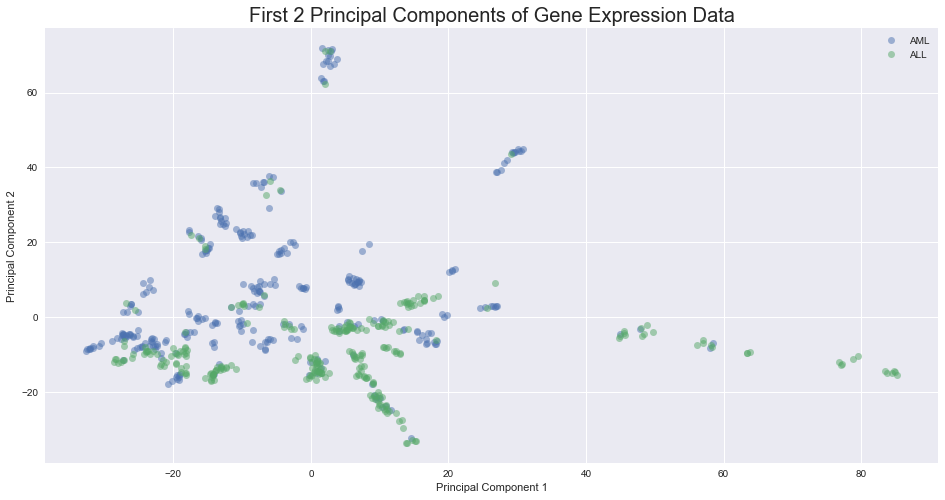

In [24]:
# Plot PCA vectors for PC1 and PC2
fig, ax = plt.subplots(figsize=(16,8))
for i in range(2):
    indices = np.where(y_train == i)[0]
    data = X_train_scaled_multi_reshape_pca_df.iloc[indices,:]
    ax.plot(data.iloc[:,0], data.iloc[:,1], 'o', label='{}'.format(i), alpha=0.5)
ax.set_title('First 2 Principal Components of Gene Expression Data', fontsize=20)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend(['AML', 'ALL']);


Because the first two PCA vectors account for the greatest proportion of the variance in the data for any two PCA vectors, they are the linear combinations of all predictors that best represent the predictors and will therefore provide the best opportunity for visualizing clusters in y given the predictors. These two PCs capture more information about the data compared to any other two PCs.

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

In [25]:
print("The Variance explained by the top 2 PCA vectors is "+str(np.sum(pca.explained_variance_[0:2])))
print("The proportion of variance explained by the top 2 PCA vectors is "+str(np.sum(pca.explained_variance_ratio_[0:2])))

The Variance explained by the top 2 PCA vectors is 801.1839845432286
The proportion of variance explained by the top 2 PCA vectors is 0.11219678772764455


The Variance explained by the top 2 PCA vectors is 801.1839845432286.

The proportion of variance explained by the top 2 PCA vectors is 0.11219678772764466.


In [26]:
ratio = pca.explained_variance_ratio_
print("We need "+str(np.argmax(np.cumsum(ratio)>0.9)+1) +" PCA vectors to explain 90% of the variability in the predictors")

We need 232 PCA vectors to explain 90% of the variability in the predictors


We need 232 PCA vectors to explain 90% of the variability in the predictors.

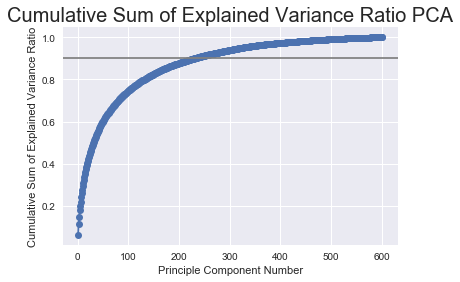

In [27]:
ratio = pca.explained_variance_ratio_
plt.plot(range(1,len(ratio)+1), np.cumsum(ratio), 'o-')
plt.title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
plt.ylabel('Cumulative Sum of Explained Variance Ratio');
plt.xlabel('Principle Component Number');
plt.axhline(0.9, color='gray')

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice in 1-3 sentences.**

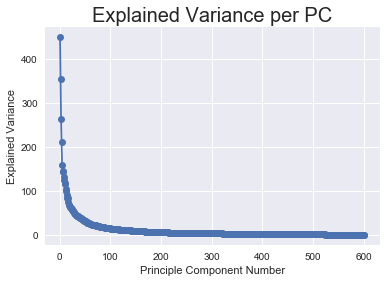

In [28]:
ratio = pca.explained_variance_
plt.plot(range(1,len(ratio)+1), ratio, 'o-')
plt.title('Explained Variance per PC', fontsize=20)
plt.ylabel('Explained Variance');
plt.xlabel('Principle Component Number');

We select the first 30 components to balance representativeness with parsimony because it is roughly at the elbow point of the plot. Additional PCs after the elbow point do not explain much more of the variance in y since the slope of the plot is not changing much after the elbow point and therefore should not be included. The elbow point represents the point of "diminishing returns" for explaining variance.

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>3.1
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>It will be good to present classification accuracies of all models in a dataframe. </span></div></div>

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [29]:
np.random.seed(10)
n = [2,30,232]
for num in n:
    pca = PCA(n_components=num).fit(X_train_standard, y_train)
    X_train_pca = pca.transform(X_train_standard)
    # Unregularized Logistic regression
    logreg_model_pca = LogisticRegression(solver='liblinear', C=1000000).fit(X_train_pca, y_train)
    y_preds_train_pca = logreg_model_pca.predict(X_train_pca)
    
    X_test_pca = pca.transform(X_test_scaled_multi_reshape)
    y_preds_test_pca = logreg_model_pca.predict(X_test_pca)
    
    print("Training set accuracy score on "+str(num)+" Principal Components: " + str(accuracy_score(y_train,y_preds_train_pca)))
    print("Test set accuracy score on "+str(num)+" Principal Components: " + str(accuracy_score(y_test,y_preds_test_pca))+"\n")

Training set accuracy score on 2 Principal Components: 0.7587354409317804
Test set accuracy score on 2 Principal Components: 0.5099337748344371

Training set accuracy score on 30 Principal Components: 0.8968386023294509
Test set accuracy score on 30 Principal Components: 0.6158940397350994

Training set accuracy score on 232 Principal Components: 1.0
Test set accuracy score on 232 Principal Components: 0.5231788079470199



With two Principal Components, the accuracy scores are smaller than those from Logistic regression with all predictors, but there is also less overfitting as there is less of a difference between the training and test set accuracy scores. The accuracy scores are also smaller than the regularized Logistic regression model and K-NN model's scores. 

With 30 Principal Components, the accuracy on the training set is smaller than those of the multiple logistic regression, regularized logistic regression, and the K-NN models. The accuracy on the test set is better than that of the multiple logistic regression and the regularized logistic regression models, but less than that of the K-NN model. 

With 232 Principal Components, the accuracy on the training set is equal to that of the multiple logistic regression model and is greater than those of the regularized logistic regression and K-NN models. The accuracy on the test set is less than those of the multiple logistic regression, regularized logistic regression, and K-NN models. 


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>3.2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great presentation and detailed interpretation! Good job.</span></div></div>

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [30]:
n = [2,20, 21, 22, 23, 24, 25, 26, 27, 28, 30,232]
np.random.seed(10)
cv_score_list = []
for num in n:
    pca = PCA(n_components=num).fit(X_train_standard, y_train)
    X_train_pca = pca.transform(X_train_standard)
    # Unregularized Logistic regression
    logreg_model_pca = LogisticRegression(solver='liblinear', C=1000000).fit(X_train_pca, y_train)
    
    cv_scores = cross_val_score(logreg_model_pca, X_train_pca, y_train, cv=5)
    print("Number of PCs: "+ str(num))
    print(cv_scores)
    print("Mean = " + str(np.mean(cv_scores))+"\n")
    cv_score_list.append(cv_scores)


Number of PCs: 2
[0.79338843 0.7768595  0.76033058 0.74789916 0.73109244]
Mean = 0.76191402180707

Number of PCs: 20
[0.88429752 0.88429752 0.85950413 0.8487395  0.90756303]
Mean = 0.8768803389124246

Number of PCs: 21
[0.89256198 0.88429752 0.8677686  0.86554622 0.88235294]
Mean = 0.8785054517674838

Number of PCs: 22
[0.90909091 0.89256198 0.87603306 0.85714286 0.8907563 ]
Mean = 0.8851170220154178

Number of PCs: 23
[0.89256198 0.89256198 0.87603306 0.86554622 0.8907563 ]
Mean = 0.8834919091603585

Number of PCs: 24
[0.90082645 0.89256198 0.85950413 0.86554622 0.88235294]
Mean = 0.8801583443294673

Number of PCs: 25
[0.90909091 0.89256198 0.87603306 0.86554622 0.8907563 ]
Mean = 0.8867976942843253

Number of PCs: 26
[0.91735537 0.89256198 0.87603306 0.85714286 0.90756303]
Mean = 0.8901312591152163

Number of PCs: 27
[0.91735537 0.89256198 0.8677686  0.86554622 0.90756303]
Mean = 0.8901590388221404

Number of PCs: 28
[0.90909091 0.89256198 0.8677686  0.8487395  0.89915966]
Mean = 0.8

Text(0,0.5,'Accuracy Score')

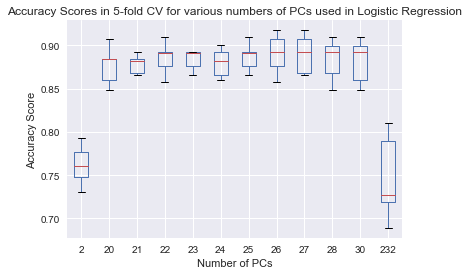

In [31]:
cv_df = pd.DataFrame(cv_score_list)
cv_df = cv_df.transpose()
cv_df.columns=[2,20, 21, 22, 23, 24, 25, 26, 27, 28, 30,232]
ax = cv_df.boxplot()
ax.set_title('Accuracy Scores in 5-fold CV for various numbers of PCs used in Logistic Regression')
ax.set_xlabel("Number of PCs")
ax.set_ylabel('Accuracy Score')

The best performing model is the model that uses 27 Principal Components. This has a high accuracy score with low variance in the scores. 

In [32]:
np.random.seed(10)
pca = PCA(n_components=27).fit(X_train_standard, y_train)
X_train_pca = pca.transform(X_train_standard)
logreg_model_pca = LogisticRegression(solver='liblinear', C=1000000).fit(X_train_pca, y_train)
coeffs = logreg_model_pca.coef_

pc_gene_coeffs = np.array(pd.DataFrame(pca.components_, columns = X_train_scaled.columns)['M31523_at'] )
print("Coefficient: "+str(np.sum(pc_gene_coeffs*coeffs)))
print("Odds change: "+str(np.exp(np.sum(pc_gene_coeffs*coeffs))))


Coefficient: -0.013387953454760673
Odds change: 0.9867012665923337


We computed the coefficient for the gene M31523_at by computing the dot product of the vector containing the coefficients for the PCs and the vector containing the coefficients for the gene M31523_at in each of the PCs.

The coefficient for the gene M31523_at in the logistic regression model is $-0.013387953454760673$. 

For every unit increase in standardized M31523_at gene expression, the change in the predicted odds of having AML versus ALL is $e^{-0.013387953454760673}=0.987$ (where the odds is the probability of having AML versus not having AML). 

This means that having this gene expressed more highly confers a lesser probabililty of having AML.

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

ROC curves show the relationship between the true positive and false positive rates for different thresholds for classification and the AUC shows the overall performance of the classifier, with higher AUC indicating better classification. The ROC curve and AUC can be compared for different models (since the units of AUC will be the same across models). Using ROC curves and AUC to evaluate models accounts for the tradeoff between true and false positive rates as classification threshold changes whereas misclassification rate (the sum of the proportion of false positives and negatives) is evaluated for one classification threshold at a time. Therefore, if the goal of the classifier is to maximize true positive rate while minimizing false positive rate, AUC can be used to identify the best classifier. Misclassification rate is more about discriminative performance of model (misclassification rate calculations are less computationally costly) while AUC is more about representative performance over a range of classification thresholds.

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [33]:
n = [2,27,30,232]
np.random.seed(10)
# y_pred_list = [y_test_multi_logreg,y_test_logreg_CV,y_test_knn]

knn = KNeighborsClassifier(7)
knn.fit(X_train_scaled_multi_reshape, y_train)
model_list = [multi_logreg, logregCV_q4, knn]
pca_list = []
for num in n:
    pca = PCA(n_components=num).fit(X_train_standard, y_train)
    X_train_pca = pca.transform(X_train_standard)
    X_test_pca = pca.transform(X_test_standard)
    # Unregularized Logistic regression
    logreg_model_pca = LogisticRegression(solver='liblinear', C=1000000).fit(X_train_pca, y_train)
    model_list.append(logreg_model_pca)
    pca_list.append(pca)
    

In [34]:
auc_list = []
fpr_list = []
tpr_list = []
for idx,l in enumerate(model_list):
    if idx < 3:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, l.predict_proba(X_test_scaled_multi_reshape)[:,1])
    else:
        X_pca_transform = pca_list[idx-3].transform(X_test_standard)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, l.predict_proba(np.array(X_pca_transform).reshape(X_pca_transform.shape[0],X_pca_transform.shape[1]))[:,1])
    auc_list.append(metrics.auc(fpr,tpr))
    fpr_list.append(fpr)
    tpr_list.append(tpr)

In [35]:
auc_df = pd.DataFrame(np.array(auc_list).reshape(1,7), columns=['Logistic Regression (unregularized)', 
                                                       'Logistic Regression (LASSO regularized)', 
                                                       'K=7 K-NN', 'Logistic Regression with 2 PCs', 
                                                       'Logistic Regression with 27 PCs', 
                                                       'Logistic Regression with 30 PCs', 
                                                       'Logistic Regression with 232 PCs'],index=['AUC'])
auc_df = auc_df.transpose()
auc_df

,AUC
Logistic Regression (unregularized),0.844156
Logistic Regression (LASSO regularized),0.856967
K=7 K-NN,0.859775
Logistic Regression with 2 PCs,0.821867
Logistic Regression with 27 PCs,0.847139
Logistic Regression with 30 PCs,0.853106
Logistic Regression with 232 PCs,0.786943


The model with the best AUC is the K-NN model (AUC=0.860).

In [36]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


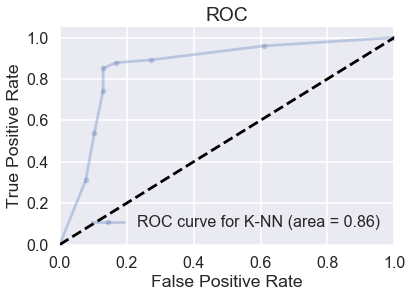

In [37]:
knn = KNeighborsClassifier(7)
knn.fit(X_train_scaled_multi_reshape, y_train)

sns.set_context("poster")
make_roc("K-NN", knn, y_test, X_test_scaled_multi_reshape, ax=None, labe=None, proba=True, skip=1);


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>3.5
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>I like your approach. Some things to consider - Rather than including all the models (Including the unregularized Logistic regression model which tends to overfit due to high dimensionality/over specificity), you can choose the top model or the top n models here. </span></div></div>

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

All of the models have AUC from approximately 0.79 to 0.86 and multiple models have quite similar AUC values (Logistic Regression (unregularized), Logistic Regression with 2 PCs, and Logistic Regression with 232 PCs all have AUC approximately in the low 0.8s while Logistic Regression (LASSO regularized), K=7 K-NN, Logistic Regression with 27 PCs, and Logistic Regression with 30 PCs have AUC approximately 0.85-0.86). If we were to predict real cancer patients, we would use all of the models to predict the cancer type for each patient and see if there is a consensus prediction across the models. If all of the models predict the same cancer type for the patient, we would trust the models because they are structurally different but confirming each other. If there is no consensus for the cancer type, then we would abstain from making any prediction and advocate for further medical testing to collect more data on the patient before cancer type can be established.

If we found that there were not many cases where a consensus was predicted and if we knew that making incorrect prections for one cancer type was clinically more devestating than for the other cancer type, we would consider modifying the models to have different classification thresholds. We would not necessarily use 0.5 as the classification threshold but instead could test 0.3 and 0.7, for example, if misclassification had different clinical consequences for the cancer types. This alternative method (versus abstention if there was not consensus) would help us make safe predictions.


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [38]:
np.random.seed(10)
compas_df = pd.read_csv('data/compas.csv')
compas_df.head()

,age,c_charge_degree,c_charge_desc,race,score_text,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
0,69,F,Aggravated Assault w/Firearm,Other,Low,Male,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
1,34,F,Felony Battery w/Prior Convict,African-American,Low,Male,0,0,0,0,3,1,10,0,0,0,0,0,0,0,1,0,10
2,24,F,Possession of Cocaine,African-American,Low,Male,4,0,0,1,4,1,1,0,1,0,0,0,1,1,0,0,1
3,44,M,Battery,Other,Low,Male,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
4,41,F,Possession Burglary Tools,Caucasian,Medium,Male,14,0,0,0,6,1,6,0,0,1,0,0,0,0,0,1,6


In [39]:
# Process dataframe by one-hot encoding categorical variables
compas_df_processed = pd.get_dummies(compas_df, columns=['c_charge_degree', 'c_charge_desc', 'race', 
                                                         'score_text', 'sex'], drop_first=True)


In [40]:
# Split the dataset into train and test sets
X_train_compas, X_test_compas, y_train_compas, y_test_compas = train_test_split(compas_df_processed.loc[:, compas_df_processed.columns != 'two_year_recid'], 
                                                         compas_df_processed['two_year_recid'], test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = compas_df.race)


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>4.2
</span></div><div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>You should not find the significant predictors using a statistical method for this question. Please refer to the HW solution
</span></div><div class='alert alert-block alert-danger'><b>Grade : </b><span style = 'color:black'>-3</span></div></div>

**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [41]:
# Inspect the data and variables available to us
display(compas_df.describe())
print(compas_df.columns)

,age,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,two_year_recid,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
count,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000
mean,34.534511,3.246436,0.059300,0.091218,0.110661,4.418503,0.455120,15.113091,0.182923,0.237200,0.242061,0.033701,0.057032,0.074692,0.182761,0.301847,0.145820,6.552171
std,11.730938,4.743770,0.463599,0.497872,0.470731,2.839463,0.498022,46.679771,0.386635,0.425401,0.428366,0.180472,0.231922,0.262915,0.386502,0.459096,0.352954,10.175818
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,31.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,42.000000,4.000000,0.000000,0.000000,0.000000,7.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,6.000000
max,96.000000,38.000000,20.000000,13.000000,9.000000,10.000000,1.000000,800.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000


Index(['age', 'c_charge_degree', 'c_charge_desc', 'race', 'score_text', 'sex',
       'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'decile_score', 'two_year_recid', 'length_of_stay', 'priors_1',
       'priors_234', 'priors_5plus', 'juv_fel_1plus', 'juv_misd_1plus',
       'juv_other_1plus', 'charge_any_drug', 'charge_any_violence_aggression',
       'charge_any_theft', 'length_of_stay_thresh'],
      dtype='object')


In [42]:
# First explore the number of observations in each racial category
compas_df.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [43]:
AA_index = (X_train_compas['race_Caucasian'] + 
             X_train_compas['race_Hispanic'] + 
             X_train_compas['race_Other'] + 
             X_train_compas['race_Asian'] + 
             X_train_compas['race_Native American'])==0

AA_index_test = (X_test_compas['race_Caucasian'] + 
             X_test_compas['race_Hispanic'] + 
             X_test_compas['race_Other'] + 
             X_test_compas['race_Asian'] + 
             X_test_compas['race_Native American'])==0

In [44]:
# Split data into train and test, dropping race from the X matrices

X_train_compas_drop = X_train_compas.drop(columns=['race_Caucasian','race_Hispanic','race_Other','race_Asian','race_Native American'])

X_train_compas_AA = X_train_compas_drop[AA_index]

X_test_compas_drop = X_test_compas.drop(columns=['race_Caucasian','race_Hispanic','race_Other','race_Asian','race_Native American'])

X_test_compas_AA = X_test_compas_drop[AA_index_test]

mean_c = np.mean(X_train_compas_drop[X_train_compas['race_Caucasian']==1])
mean_aa = np.mean(X_train_compas_AA)
var_c = np.var(X_train_compas_drop[X_train_compas['race_Caucasian']==1])
var_aa = np.var(X_train_compas_AA)

# Calculating t_statistics
t_scores = np.abs(mean_c - mean_aa)/np.sqrt((var_c/len(X_train_compas_drop[X_train_compas['race_Caucasian']==1])+
                                             var_aa/len(X_train_compas_AA)))
# Sort t_statistics in descending order
t_scores = t_scores.sort_values(ascending=False)

In [45]:
# Display t statistic for each variable
t_scores_df = pd.DataFrame(t_scores,columns=["t statistic"])
t_scores_df.head()

,t statistic
decile_score,19.155067
score_text_Low,15.726110
priors_count,13.653106
age,13.010745
priors_5plus,11.979558


The variables decile_score, priors_count, and age appear to have significant differences between Caucasians and African Americans according to these t-test scores (these appear to best individually discriminate between the two races the best) and since the t statistics for each variable (19.2, 13.7, and 13.0, respectively) are larger than the threshold for statistical signifance at the alpha = 0.05 level (95% confidence), we suspect they are signifiantly different between the two racial groups. When choosing the top three variables that best discriminate African Americans from Caucasians, we did not consider the t statistics for categorical variables (such as score_text_Low) because t tests on these variables are not sound (since the categorical variables cannot be considered normally distributed). To explore the categorical variables, we plotted several histograms and observed differences in the skew across racial groups.

In [46]:
print('Mean of decile score for Caucasians in training set:', mean_c['decile_score'])
print('Variance of decile score for Caucasians in training set:', var_c['decile_score'])
print('Mean of decile score for African Americans in training set:', mean_aa['decile_score'])
print('Variance of decile score for African Americans in training set:', var_aa['decile_score'],'\n')

print('Mean number of prior charges for Caucasians in training set:', mean_c['priors_count'])
print('Variance of number of prior charges for Caucasians in training set:', var_c['priors_count'])
print('Mean number of prior charges for African Americans in training set:', mean_aa['priors_count'])
print('Variance of number of prior charges for African Americans in training set:', var_aa['priors_count'],'\n')

print('Mean age for Caucasians in training set:', mean_c['age'])
print('Variance of age for Caucasians in training set:', var_c['age'])
print('Mean age for African Americans in training set:', mean_aa['age'])
print('Variance of age for African Americans in training set:', var_aa['age'],'\n')

Mean of decile score for Caucasians in training set: 3.6664684898929845
Variance of decile score for Caucasians in training set: 6.6134891931212785
Mean of decile score for African Americans in training set: 5.280708661417322
Variance of decile score for African Americans in training set: 8.051517608035262 

Mean number of prior charges for Caucasians in training set: 2.310344827586207
Variance of number of prior charges for Caucasians in training set: 13.311533888228368
Mean number of prior charges for African Americans in training set: 4.223228346456693
Variance of number of prior charges for African Americans in training set: 29.757649420298748 

Mean age for Caucasians in training set: 37.356718192627824
Variance of age for Caucasians in training set: 161.63256188134568
Mean age for African Americans in training set: 32.4740157480315
Variance of age for African Americans in training set: 113.64302560605134 



Text(0.5,0,'decile_score')

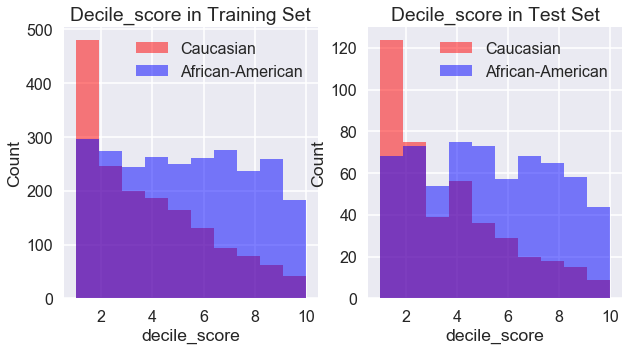

In [47]:
plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2)
# Training set histogram
ax1.hist(X_train_compas[X_train_compas['race_Caucasian']==1]['decile_score'], color = 'red', alpha = 0.5, label='Caucasian')
ax1.hist(X_train_compas_AA['decile_score'], color = 'blue', alpha = 0.5, label='African-American')
ax1.legend()
ax1.set_title("Decile_score in Training Set")
ax1.set_ylabel("Count")
ax1.set_xlabel("decile_score")
# Test set histogram
ax2.hist(X_test_compas[X_test_compas['race_Caucasian']==1]['decile_score'], color = 'red', alpha = 0.5, label='Caucasian')
ax2.hist(X_test_compas_AA['decile_score'], color = 'blue', alpha = 0.5, label='African-American')
ax2.legend()
ax2.set_title("Decile_score in Test Set")
ax2.set_ylabel("Count")
ax2.set_xlabel("decile_score")

Text(0.5,0,'age')

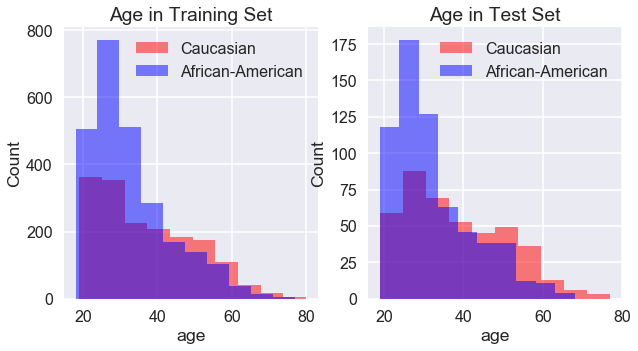

In [48]:
plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2)
# Training set histogram
ax1.hist(X_train_compas[X_train_compas['race_Caucasian']==1]['age'], color = 'red', alpha = 0.5, label='Caucasian')
ax1.hist(X_train_compas_AA['age'], color = 'blue', alpha = 0.5, label='African-American')
ax1.legend()
ax1.set_title("Age in Training Set")
ax1.set_ylabel("Count")
ax1.set_xlabel("age")
# Test set histogram
ax2.hist(X_test_compas[X_test_compas['race_Caucasian']==1]['age'], color = 'red', alpha = 0.5, label='Caucasian')
ax2.hist(X_test_compas_AA['age'], color = 'blue', alpha = 0.5, label='African-American')
ax2.legend()
ax2.set_title("Age in Test Set")
ax2.set_ylabel("Count")
ax2.set_xlabel("age")

Text(0.5,0,'priors_count')

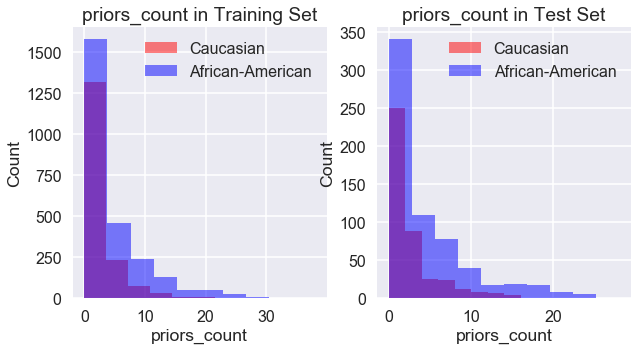

In [49]:
plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2)
# Training set histogram
ax1.hist(X_train_compas[X_train_compas['race_Caucasian']==1]['priors_count'], color = 'red', alpha = 0.5, label='Caucasian')
ax1.hist(X_train_compas_AA['priors_count'], color = 'blue', alpha = 0.5, label='African-American')
ax1.legend()
ax1.set_title("priors_count in Training Set")
ax1.set_ylabel("Count")
ax1.set_xlabel("priors_count")
# Test set histogram
ax2.hist(X_test_compas[X_test_compas['race_Caucasian']==1]['priors_count'], color = 'red', alpha = 0.5, label='Caucasian')
ax2.hist(X_test_compas_AA['priors_count'], color = 'blue', alpha = 0.5, label='African-American')
ax2.legend()
ax2.set_title("priors_count in Test Set")
ax2.set_ylabel("Count")
ax2.set_xlabel("priors_count")

Although the t statistic does not apply to categorical variables, we decided to explore whether score_text_Low (a one-hot encoded categorical variable representing an offender being in the low risk category for recidivism) had different distributions for African Americans compared to Caucasians. We suspected that there would be differences between the races for this group since decile_score (continuous variable indicating risk of recidivism) differed significantly. 

Text(0.5,0,'score_text_Low')

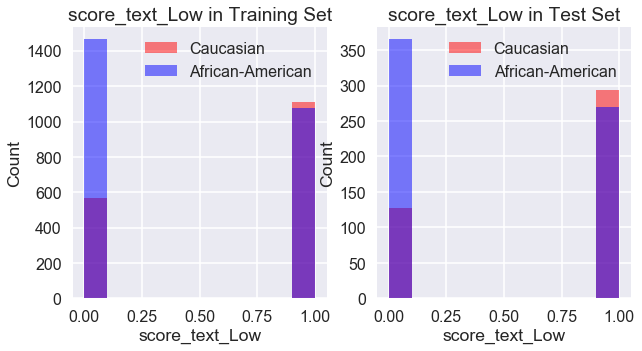

In [50]:
plt.rcParams["figure.figsize"] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2)
# Training set histogram
ax1.hist(X_train_compas[X_train_compas['race_Caucasian']==1]['score_text_Low'], color = 'red', alpha = 0.5, label='Caucasian')
ax1.hist(X_train_compas_AA['score_text_Low'], color = 'blue', alpha = 0.5, label='African-American')
ax1.legend()
ax1.set_title("score_text_Low in Training Set")
ax1.set_ylabel("Count")
ax1.set_xlabel("score_text_Low")
# Test set histogram
ax2.hist(X_test_compas[X_test_compas['race_Caucasian']==1]['score_text_Low'], color = 'red', alpha = 0.5, label='Caucasian')
ax2.hist(X_test_compas_AA['score_text_Low'], color = 'blue', alpha = 0.5, label='African-American')
ax2.legend()
ax2.set_title("score_text_Low in Test Set")
ax2.set_ylabel("Count")
ax2.set_xlabel("score_text_Low")

In [51]:
print('Proportion of Caucasians in the Low category for score_text (in training set):', np.sum(X_train_compas[X_train_compas['race_Caucasian']==1]['score_text_Low'])/len(X_train_compas[X_train_compas['race_Caucasian']==1]))
print('Proportion of African Americans in the Low category for score_text (in training set):', np.sum(X_train_compas_AA['score_text_Low'])/len(X_train_compas_AA['score_text_Low']))
print('Proportion of Caucasians in the Low category for score_text (in testing set):', np.sum(X_test_compas[X_test_compas['race_Caucasian']==1]['score_text_Low'])/len(X_test_compas[X_test_compas['race_Caucasian']==1]))
print('Proportion of African Americans in the Low category for score_text (in testing set):', np.sum(X_test_compas_AA['score_text_Low'])/len(X_test_compas_AA['score_text_Low']))



Proportion of Caucasians in the Low category for score_text (in training set): 0.6617122473246135
Proportion of African Americans in the Low category for score_text (in training set): 0.42362204724409447
Proportion of Caucasians in the Low category for score_text (in testing set): 0.6983372921615202
Proportion of African Americans in the Low category for score_text (in testing set): 0.4251968503937008


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

In [52]:
compas_df_dict = pd.read_csv('data/compas_datadict.csv')
compas_df_dict.index = compas_df_dict.Variable
compas_df_dict2 = compas_df_dict.drop('Variable',1)
compas_df_dict3 = compas_df_dict2.iloc[1:,:]

print(compas_df_dict3.loc['decile_score',:])
print(compas_df_dict3.loc['priors_count',:])
print(compas_df_dict3.loc['Age',:])



Description    1-10 COMPAS score based on decile
Name: decile_score, dtype: object
Description    Count for number of prior times a defendant ha...
Name: priors_count, dtype: object
Description    Defendant's age in years
Name: Age, dtype: object


Three quantiative variables that differ between African-Americans and Caucasians are decile_score representing a normalized ranking of risk of recidivism), priors_count (number of prior times a defendant has been charged), and age (of the defendant). The histograms show that the distribution of decile score for Caucasians is shifted left (favor toward lower decile scores, i.e., less risk for recidivism) while the decile scores for African-Americans are more uniform (more higher decile scores recorded). There are more young defendants (under age 40) for African-Americans compared to Caucasians. There is also more of a left-skew for African-Americans for the number of prior charges compared to Caucasians. The left-skew of the prior charges and more uniform distribution of decile scores along with the younger age of defendants in African-Americans could be explained by having more thorough data collection for worse crimes in African-Americans than for the other races (perhaps due to systemic racism or tendency for law enforcement to patrol African-American neighborhoods, especially where young people are located). Consequently, there could be more fully missing entries in the database for other races compared to African-Americans (which we would have no way to recover assuming that the instances are missing completely at random), making the African-Americans appear to have an apparently greater risk of recidivism (really just more missing data for the Caucasians for the worse crimes) compared to Caucasians. (For the categorical variable we explored (score_text_Low), the plots show that more Caucasians are in the low category for recidivism compared to African-Americans.)

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [53]:
# Logistic Model with regularization
np.random.seed(10)
Cs = 10.0**np.arange(-5,5)
compas_logistic = LogisticRegressionCV(Cs = Cs,cv=5,solver='liblinear',penalty='l1')
# Use liblinear solver because it is best for small samples and so has high power and leave max_iter at the default of 100 because model converges with it and is more efficient than using higher numbers for max_iter
# Use a range of Cs as shown in the lab and use cv = 5 to perform 5-fold cross validation as modeled in the lab
compas_logistic_model = compas_logistic.fit(X_train_compas, y_train_compas)


In [54]:
# Predictions on training set
compas_pred_logreg_train = compas_logistic_model.predict(X_train_compas)

# Predictions on testing set
compas_pred_logreg_test = compas_logistic_model.predict(X_test_compas)

# Evaluate accuracy on training set
print('Regularized logistic regression misclassification rate on training set:', 1-accuracy_score(y_train_compas, compas_pred_logreg_train))

# Evaluate accuracy on testing set
print('Regularized logistic regression misclassification rate on testing set:', 1-accuracy_score(y_test_compas, compas_pred_logreg_test))

Regularized logistic regression misclassification rate on training set: 0.29937208831274054
Regularized logistic regression misclassification rate on testing set: 0.3157894736842105


In [55]:
logreg_compas_AA=pd.crosstab(y_test_compas[AA_index_test], compas_pred_logreg_test[AA_index_test], colnames=['Predicted'], rownames=['Actual'])
logreg_compas_C=pd.crosstab(y_test_compas[X_test_compas['race_Caucasian']==1], compas_pred_logreg_test[X_test_compas['race_Caucasian']==1], colnames=['Predicted'], rownames=['Actual'])


#### Confusion matrix and FPR and FNR for Logistic Regression model with race as a predictor for Caucasians:

In [56]:
logreg_compas_C

Predicted,0,1
Actual,,
0,224,40
1,79,78


In [57]:
print("The false positive rate is "+str(logreg_compas_C[1][0]/(logreg_compas_C[1][0] + logreg_compas_C[0][0])))
print("The false negative rate is "+str(logreg_compas_C[0][1]/(logreg_compas_C[0][1] + logreg_compas_C[1][1])))


The false positive rate is 0.15151515151515152
The false negative rate is 0.5031847133757962


#### Confusion matrix and FPR and FNR for Logistic Regression model with race as a predictor for African Americans:

In [58]:
logreg_compas_AA

Predicted,0,1
Actual,,
0,209,101
1,106,219


In [59]:
print("The false positive rate is "+str(logreg_compas_AA[1][0]/(logreg_compas_AA[1][0] + logreg_compas_AA[0][0])))
print("The false negative rate is "+str(logreg_compas_AA[0][1]/(logreg_compas_AA[0][1] + logreg_compas_AA[1][1])))


The false positive rate is 0.3258064516129032
The false negative rate is 0.3261538461538461


In [60]:
# k-NN Model
np.random.seed(10)
ks = [1,2,3,4,5,7,9,10,15,25]
cv_score_list=np.array([])
for k in ks:
    knn = KNeighborsClassifier(k)
    cv_score_list = np.append(cv_score_list, np.mean(cross_val_score(knn, X_train_compas, y_train_compas, cv=5)))

k=ks[np.argmax(cv_score_list)]
knn = KNeighborsClassifier(k)
knn.fit(X_train_compas, y_train_compas)
print("K-NN model with k = " + str(k)+" chosen.")

K-NN model with k = 25 chosen.


In [61]:
# Predictions on training set
compas_pred_knn_train = knn.predict(X_train_compas)

# Predictions on testing set
compas_pred_knn_test = knn.predict(X_test_compas)

# Evaluate accuracy on training set
print('K=25 k-NN misclassification rate on training set:', 1-accuracy_score(y_train_compas, compas_pred_knn_train))

# Evaluate accuracy on testing set
print('K=25 k-NN misclassification rate on testing set:', 1-accuracy_score(y_test_compas, compas_pred_knn_test))

K=25 k-NN misclassification rate on training set: 0.2965363581122139
K=25 k-NN misclassification rate on testing set: 0.3263157894736842


#### Confusion matrix and FPR and FNR for KNN model with race as a predictor for Caucasians:

In [62]:
knn_compas_AA=pd.crosstab(y_test_compas[AA_index_test], compas_pred_knn_test[AA_index_test], colnames=['Predicted'], rownames=['Actual'])
knn_compas_C = pd.crosstab(y_test_compas[X_test_compas['race_Caucasian']==1], compas_pred_knn_test[X_test_compas['race_Caucasian']==1], colnames=['Predicted'], rownames=['Actual'])

knn_compas_C

Predicted,0,1
Actual,,
0,212,52
1,83,74


In [63]:
print("The false positive rate is "+str(knn_compas_C[1][0]/(knn_compas_C[1][0] + knn_compas_C[0][0])))
print("The false negative rate is "+str(knn_compas_C[0][1]/(knn_compas_C[0][1] + knn_compas_C[1][1])))


The false positive rate is 0.19696969696969696
The false negative rate is 0.5286624203821656


#### Confusion matrix and FPR and FNR for KNN model with race as a predictor for African Americans:

In [64]:
knn_compas_AA

Predicted,0,1
Actual,,
0,212,98
1,108,217


In [65]:
print("The false positive rate is "+str(knn_compas_AA[1][0]/(knn_compas_AA[1][0] + knn_compas_AA[0][0])))
print("The false negative rate is "+str(knn_compas_AA[0][1]/(knn_compas_AA[0][1] + knn_compas_AA[1][1])))


The false positive rate is 0.3161290322580645
The false negative rate is 0.3323076923076923


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [66]:
# Logistic Model with regularization
np.random.seed(10)
Cs = 10.0**np.arange(-5,5)
compas_logistic = LogisticRegressionCV(Cs = Cs,cv=5,solver='liblinear',penalty='l1')
# Use liblinear solver because it is best for small samples and so has high power and leave max_iter at the default of 100 because model converges with it and is more efficient than using higher numbers for max_iter
# Use a range of Cs as shown in the lab and use cv = 5 to perform 5-fold cross validation as modeled in the lab
compas_logistic_model = compas_logistic.fit(X_train_compas_drop, y_train_compas)


In [67]:
# Predictions on training set
compas_pred_logreg_train = compas_logistic_model.predict(X_train_compas_drop)

# Predictions on testing set
compas_pred_logreg_test = compas_logistic_model.predict(X_test_compas_drop)

# Evaluate accuracy on training set
print('Regularized logistic regression misclassification rate on training set:', 1-accuracy_score(y_train_compas, compas_pred_logreg_train))

# Evaluate accuracy on testing set
print('Regularized logistic regression misclassification rate on testing set:', 1-accuracy_score(y_test_compas, compas_pred_logreg_test))

Regularized logistic regression misclassification rate on training set: 0.2991695361555601
Regularized logistic regression misclassification rate on testing set: 0.3165991902834008


For the Regularized logistic regression model, 

Regularized logistic regression misclassification rate on training set: 0.2991695361555601

Regularized logistic regression misclassification rate on testing set: 0.3165991902834008

#### Confusion matrix and FPR and FNR for logistic regression model for Caucasians without race as a predictor:

In [68]:
logreg_compas_AA = pd.crosstab(y_test_compas[AA_index_test], compas_pred_logreg_test[AA_index_test], colnames=['Predicted'], rownames=['Actual'])
logreg_compas_C = pd.crosstab(y_test_compas[X_test_compas['race_Caucasian']==1], compas_pred_logreg_test[X_test_compas['race_Caucasian']==1], colnames=['Predicted'], rownames=['Actual'])

logreg_compas_C

Predicted,0,1
Actual,,
0,224,40
1,80,77


In [69]:
print("The false positive rate is "+str(logreg_compas_C[1][0]/(logreg_compas_C[1][0] + logreg_compas_C[0][0])))
print("The false negative rate is "+str(logreg_compas_C[0][1]/(logreg_compas_C[0][1] + logreg_compas_C[1][1])))


The false positive rate is 0.15151515151515152
The false negative rate is 0.5095541401273885


#### Confusion matrix and FPR and FNR for logistic regression model for African Americans without race as a predictor:

In [70]:
logreg_compas_AA

Predicted,0,1
Actual,,
0,209,101
1,106,219


In [71]:
print("The false positive rate is "+str(logreg_compas_AA[1][0]/(logreg_compas_AA[1][0] + logreg_compas_AA[0][0])))
print("The false negative rate is "+str(logreg_compas_AA[0][1]/(logreg_compas_AA[0][1] + logreg_compas_AA[1][1])))


The false positive rate is 0.3258064516129032
The false negative rate is 0.3261538461538461


In [72]:
# k-NN Model
np.random.seed(10)
k=25
knn = KNeighborsClassifier(k)
knn.fit(X_train_compas_drop, y_train_compas);

In [73]:
# Predictions on training set
compas_pred_knn_train = knn.predict(X_train_compas_drop)

# Predictions on testing set
compas_pred_knn_test = knn.predict(X_test_compas_drop)

# Evaluate accuracy on training set
print('K=25 k-NN misclassification rate on training set:', 1-accuracy_score(y_train_compas, compas_pred_knn_train))

# Evaluate accuracy on testing set
print('K=25 k-NN misclassification rate on testing set:', 1-accuracy_score(y_test_compas, compas_pred_knn_test))

K=25 k-NN misclassification rate on training set: 0.2947133886975897
K=25 k-NN misclassification rate on testing set: 0.33117408906882595


For the k-NN model, 

K=25 k-NN misclassification rate on training set: 0.2947133886975897

K=25 k-NN misclassification rate on testing set: 0.33117408906882595

#### Confusion matrix and FNR and FPR for KNN model for Caucasians without race as a predictor:

In [74]:
knn_compas_C = pd.crosstab(y_test_compas[X_test_compas['race_Caucasian']==1], compas_pred_knn_test[X_test_compas['race_Caucasian']==1], colnames=['Predicted'], rownames=['Actual'])
knn_compas_AA = pd.crosstab(y_test_compas[AA_index_test], compas_pred_knn_test[AA_index_test], colnames=['Predicted'], rownames=['Actual'])

knn_compas_C

Predicted,0,1
Actual,,
0,211,53
1,86,71


In [75]:
print("The false positive rate is "+str(knn_compas_C[1][0]/(knn_compas_C[1][0] + knn_compas_C[0][0])))
print("The false negative rate is "+str(knn_compas_C[0][1]/(knn_compas_C[0][1] + knn_compas_C[1][1])))


The false positive rate is 0.20075757575757575
The false negative rate is 0.5477707006369427


#### Confusion matrix and FNR and FPR for KNN model for African Americans without race as a predictor:

In [76]:
knn_compas_AA

Predicted,0,1
Actual,,
0,209,101
1,110,215


In [77]:
print("The false positive rate is "+str(knn_compas_AA[1][0]/(knn_compas_AA[1][0] + knn_compas_AA[0][0])))
print("The false negative rate is "+str(knn_compas_AA[0][1]/(knn_compas_AA[0][1] + knn_compas_AA[1][1])))


The false positive rate is 0.3258064516129032
The false negative rate is 0.3384615384615385


For the regularized logistic regression model, the misclassification rate on the training set is 0.2991695361555601

The regularized logistic regression model's misclassification rate on testing set is 0.3165991902834008

For the k-NN model, the misclassification rate on the training set is 0.2947133886975897.

The k-NN model's misclassification rate on the testing set is 0.33117408906882595

Looking at the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set, we see a pretty consistent pattern:

1. The false negative and false positive rates for African Americans were roughly equivalent, around 0.32-0.33. 
2. For Caucasians, the false positive rate was significantly lower than the false negative rate (FPR=0.2, FNR=0.55).

Compared to the models when race is included as a predictor, these trends still hold true. The FPR and FNR were roughly equal for African Americans at about 0.32-0.33, while the Caucasians' FPR was significantly lower than their FNR. 

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

A predictive tool should not be trusted to be unbiased even if it doesn't explicitly use a variable such as race to predict future crimes because other variables included in the model could be collinear or related to race such that including those other variables has a similar effect on the model as including race (which could be considered a morally irrelevant feature to include in a model predicting recidivism). In the case of this problem, features such as priors_count (number of previous charges), charge_any_drug ("best guess as to whether the crime charged was drug-related"), 'juv_fel_count' (number of felonies as a child), 'juv_misd_count' (number of misdemeanor as a child), and 'juv_other_count' (number of other charges besides felonies and misdemeanors) could all be confounded by race if being African-American predisposes the defendant to have higher values for these variables. The effect of race on these other variables may not be apparent in the model (because there is no clear way to parse out the effect of race on each of these predictors without including race in the model) but may still bias the predictions. It is possible that these predictors are affected by race because it is known that communities in the US may be dominated by certain racial groups and upbringing in these communities may result in more patrol by police, exposure to drugs, and other factors.

---

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Checked by: Lekshmi Santhosh
</footer>